## Data Cleaning

This data is scrapped and very messy. It does not come with a dictionary and I do not have access to the code that generated it to provide any insight about the variables gathered.

These data were scrapped in September 2020 and is provided in .CSV format. In this notebook I will only be cleaning up the data and saving in in parquet format which is more efficent for large datasets.

I will focus on creating a function that can be applied to the data so that it could become part of a pipeline and produce repeatable, scaleable results.

---
#### Imports and defined functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dask import delayed
from dask.distributed import Client, progress
import dask.array as da
import dask.dataframe as dd
import joblib
import pandas as pd
import spacy

import warnings
#warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format
sns.set(style='whitegrid', palette='colorblind', color_codes=True, font_scale=2)

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def print_nulls(ddf):
    out = ddf.isnull().sum()*100/ddf.isnull().isnull().count()
    
    return print_full(out.compute())

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

In [4]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36459 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 84.47 GB


In [5]:
# List the columns that I am going to use
# Many columns contain duplicate or unnecessary information. These are the essential features

kept = ['vin' 
        , 'make_name' # Use make and body type instead of model
        #, 'model_name'
        , 'body_type'
        , 'year'
        , 'engine_type' # This contains the number of cylnders as well as their configureation.   
        , 'wheel_system'
        , 'transmission'
        #, 'trimId'
        #, 'trim_name'
        , 'horsepower'
        , 'maximum_seating'
        , 'mileage'
        
        
        # Target Variable
        , 'price'

        # Fuel Economy Variables
        , 'fuel_type'  
        , 'city_fuel_economy'
        , 'highway_fuel_economy'
        , 'combine_fuel_economy'

        , 'daysonmarket'
        , 'franchise_dealer'
        , 'is_cpo'
        
        # These Features would need NLP
        #, 'description'
        #, 'major_options'
        #, 'exterior_color'
        #, 'interior_color'

        # Low nulls but probably just noise
        #, 'front_legroom'
        #, 'back_legroom'
        #, 'height'
        #, 'length'
        #, 'width'

        # Vehicle History Features
        , 'owner_count'
        , 'has_accidents'       
        , 'salvage'
        , 'theft_title'
        , 'fleet'
        , 'frame_damaged'
        , 'isCab' # Guessing this indicates that it was used for ridesharing?
        
        # Location information not currently utilized
        #, 'dealer_zip'
        #, 'latitude'
        #, 'longitude'
       ]

In [6]:
# read the first 10,000 rows in pandas to do understand the column types
df = pd.read_csv(r'used_cars_data.csv', usecols=kept, nrows=10000)

In [7]:
# Use the pandas type assignments for dask
dtypes = {col : df[col].dtype for col in df.columns}

# This contains problem values probably 4 digit codes
#dtypes['dealer_zip'] = 'O'

In [8]:
# Keep only the dtypes for the columns that I want
#dtypes = {key : dtypes[key] for key in dtypes if key in kept}

#df = dd.from_pandas(df, npartitions=5)

df = dd.read_csv('used_cars_data.csv', usecols=kept, dtype=dtypes)

In [9]:
print_nulls(df)

vin                      0.000
body_type                0.451
city_fuel_economy       16.376
combine_fuel_economy   100.000
daysonmarket             0.000
engine_type              3.353
fleet                   47.553
frame_damaged           47.553
franchise_dealer         0.000
fuel_type                2.757
has_accidents           47.553
highway_fuel_economy    16.376
horsepower               5.746
isCab                   47.553
is_cpo                  93.903
make_name                0.000
maximum_seating          5.309
mileage                  4.813
owner_count             50.566
price                    0.000
salvage                 47.553
theft_title             47.553
transmission             2.139
wheel_system             4.891
year                     0.000
dtype: float64


In [10]:
df.shape[0].compute()

3000040

In [11]:
def clean(df):
    ### Operations to clean the dataset
    '''
    In this iteration it is mostly some simple fixes to retain and retype easy to clean data.
    Almost half the data are being dropped because they lack car history values.

    Some notes are included for currently unused columns.
    '''

    #First Drop Duplicates
    df = df.drop_duplicates(subset='vin')

    # Use only cars produced in the last 20 years
    df = df[df['year'] >= 2000]
    '''
    This helps remove outliers in the dataset overall and limits the influence of 
    collector cars since this is aimed toward the general consumer
    '''

    # Clean up boolean columns into numerical
    df['is_cpo'] = df['is_cpo'].apply(lambda x: 1 if x == 'True' else 0, meta=('is_cpo', 'int8'))

    df['franchise_dealer'] = df['franchise_dealer'].apply(lambda x: 1 if x == True else 0
                                                          , meta=('franchise_dealer', 'int8'))

    df['fleet'] = df['fleet'].apply(lambda x: 1 if x == 'True' else (0 if x == 'False' else np.nan)
                                    , meta=('fleet', 'int8'))

    df['frame_damaged'] = df['frame_damaged'].apply(lambda x: 1 if x == 'True' else (0 if x == 'False' else np.nan)
                                                   , meta=('frame_damaged', 'int8'))

    df['isCab'] = df['isCab'].apply(lambda x: 1 if x == 'True' else (0 if x == 'False' else np.nan)
                                   , meta=('isCab', 'int8'))

    df['has_accidents'] = df['has_accidents'].apply(lambda x: 1 if x == 'True' else (0 if x == 'False' else np.nan)
                                                   , meta=('has_accidents', 'int8'))

    df['salvage'] = df['salvage'].apply(lambda x: 1 if x == 'True' else(0 if x == 'False' else np.nan)
                                       , meta=('salvage', 'int8'))

    df['theft_title'] = df['theft_title'].apply(lambda x: 1 if x == 'True' else(0 if x == 'False' else np.nan)
                                               , meta=('theft_title', 'int8'))

    # Clean and retype seating capacity 
    def fix_seating(r):
        try:
            r = int(str(r).strip(' seats'))
            return r
        except:
            return np.nan

    df['maximum_seating'] = df['maximum_seating'].apply(fix_seating, meta=
                                                        ('maximum_seating', 'int64'))
    # Decide what to do about fuel economy
    '''
    It could be best to calculate an overall cost of ownership that would take fuel into account.
    Within this model currently there is not a good option to assign a fuel economy value to electric 
    vehicles

    Drop the component features due to correlation problems
    '''

    # EPA generates combined by weighting city 55% and highway 45%
    df['combine_fuel_economy'] = df['city_fuel_economy']*0.55 + df['highway_fuel_economy']*0.45

    df = df.drop(['city_fuel_economy', 'highway_fuel_economy'], axis=1)


    # Drop almost half the dataset because it is missing history?, Drop those features?
    '''
    In this pass I'm going to retain these columns and shrink the data. 
    There is still more than enough and this way I may be able to create a classifier to
    recommend if purchasing history will be worth it or not.

    In the overall dataset these values have a null rate of about 48%


    ['fleet'
    , 'frame_damaged'
    , 'isCab'
    , 'has_accidents'
    , 'salvage'
    , 'theft_title']

    '''

    # Color and Description both need to be parsed
    '''
    Just dropping them in this pass
    '''    

    # Define a function to retype columns with unit inches
    '''
    def strip_inches(t):
        try:
            t = float(str(t).strip(' in'))
            return t
        except:
            return np.nan

    cols = ['back_legroom', 'front_legroom', 'height', 'width', 'length']

    for col in cols:
        df[col] = df[col].apply(strip_inches, meta=(col, 'int64'))
    '''    

    # See if I can bin TrimID better
    '''
    Drop them in this pass
    '''
    
    # Drop the remaining nulls
    '''
    Unfortounately at this point that includes all vehicles that are primarily electric
    because they have null fuel economy values
    
    A possible fix for this would be to use fuel economy and the cost of fuel to calculate a 
    price per mile. EPA has data that could be used to produce these estimates
    '''
    
    # Drop the remaining null values
    df = df.dropna()
    
    
    # Use the history variables to encode the target. 
    # If any of these values are true consider the report information valueable

    def encode_target(df):
        if df['has_accidents'] > 0: 
            return 1
        elif df['salvage'] > 0: 
            return 1
        elif df['theft_title'] > 0: 
            return 1
        elif df['frame_damaged'] > 0: 
            return 1
        else: 
            return 0

    df['target'] = df.apply(encode_target, axis=1, meta=('target', 'int8'))

    # Drop the component features, as well as owner count which is a history variable
    df = df.drop(['has_accidents', 'owner_count', 'salvage', 'theft_title'
                        , 'frame_damaged', 'isCab', 'fleet'], axis=1)
    
    # Use vin as index?
    '''
    May additionally need to add a vin checker here
    '''
                 
    df = df.set_index('vin')

                 
    return df


In [12]:
df = clean(df)

In [13]:
df.shape[0].compute()

1222797

In [14]:
print_nulls(df)

body_type              0.000
combine_fuel_economy   0.000
daysonmarket           0.000
engine_type            0.000
franchise_dealer       0.000
fuel_type              0.000
horsepower             0.000
is_cpo                 0.000
make_name              0.000
maximum_seating        0.000
mileage                0.000
price                  0.000
transmission           0.000
wheel_system           0.000
year                   0.000
target                 0.000
dtype: float64


In [15]:
df = df.dropna()

df.shape[0].compute()

1222797

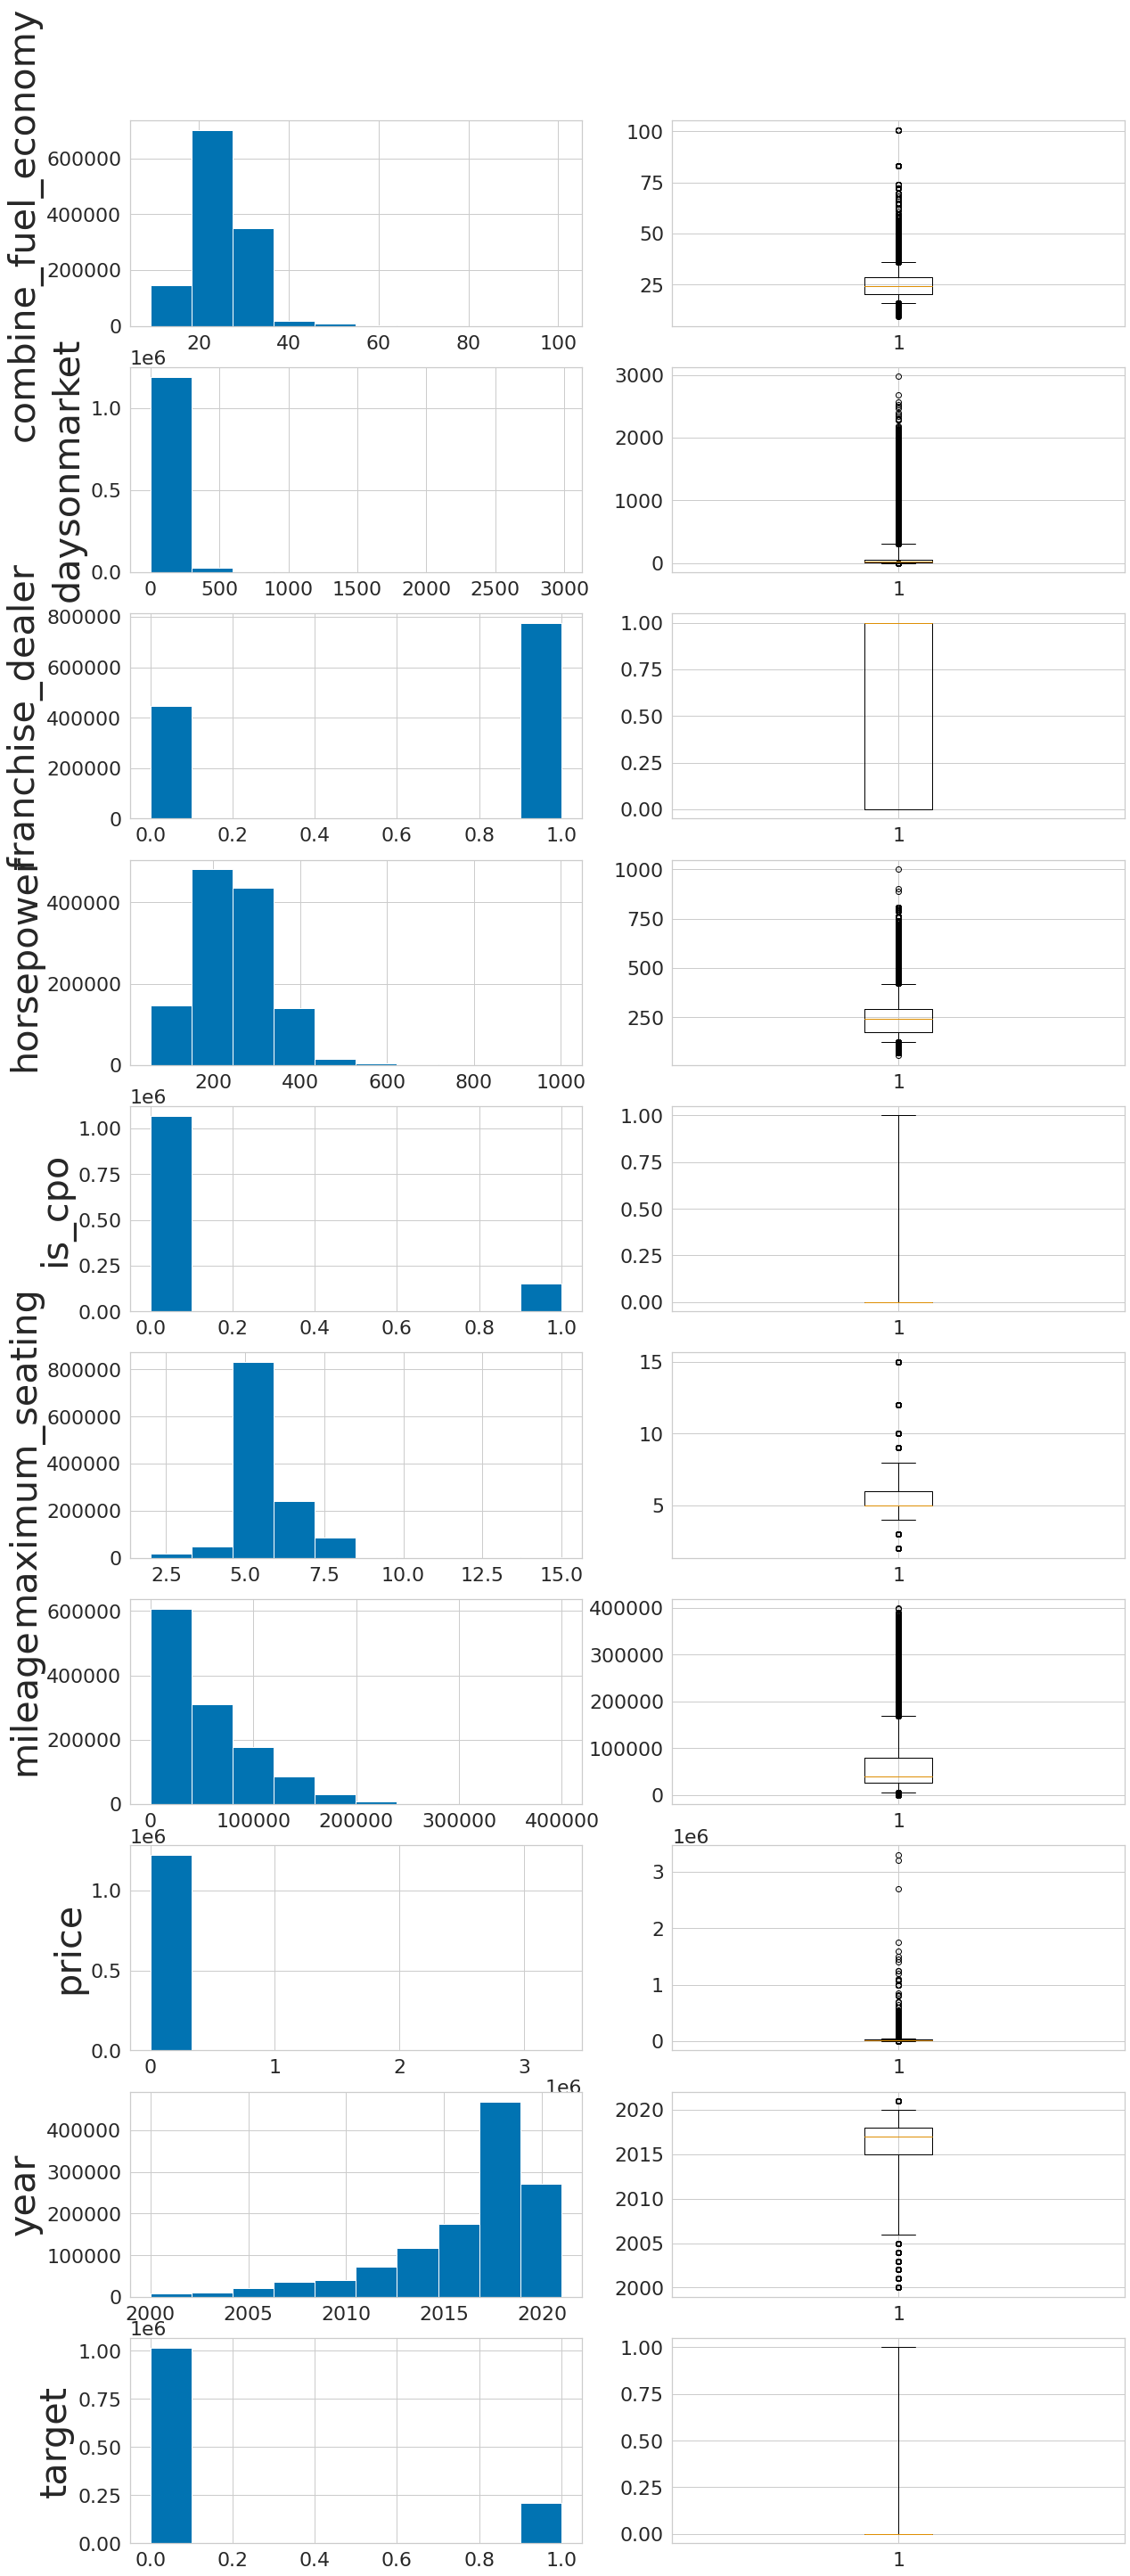

In [16]:
## Visualize distributions and outliers of numerical columns
plot_hist_boxplot(df.select_dtypes(include='number').compute())

In [17]:
# Price appears to have some extreme outliers
df['price'].describe().compute()

count   1222797.000
mean      21883.086
std       15823.252
min         299.000
25%       13900.000
50%       18998.000
75%       27500.000
max     3299995.000
Name: price, dtype: float64

In [18]:
np.percentile(df['price'], 95)

42999.0

In [19]:
np.percentile(df['price'], 99)

62315.520000000484

In [20]:
np.percentile(df['price'], 99.9)

160017.3400000122

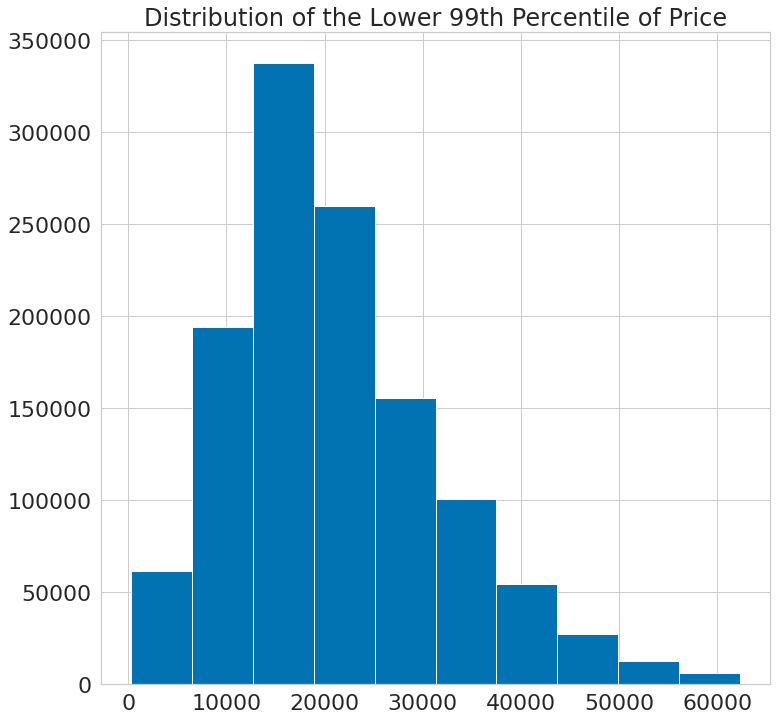

In [21]:
plt.figure(figsize=(12,12))
plt.hist(df[df['price'] < np.percentile(df['price'], 99)]['price'])
plt.title('Distribution of the Lower 99th Percentile of Price')
plt.show()

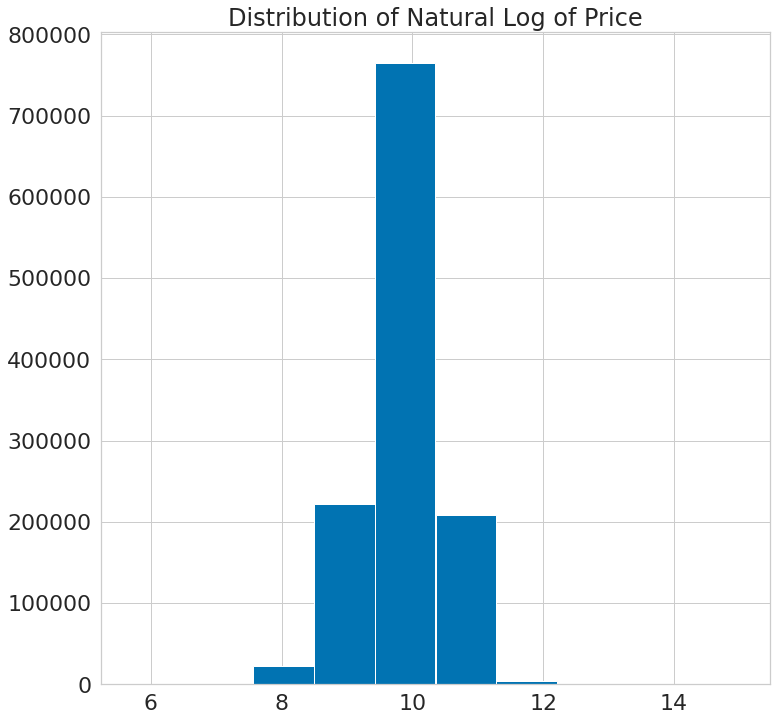

In [22]:
plt.figure(figsize=(12,12))
plt.hist(np.log(df['price']))
plt.title('Distribution of Natural Log of Price')
plt.show()

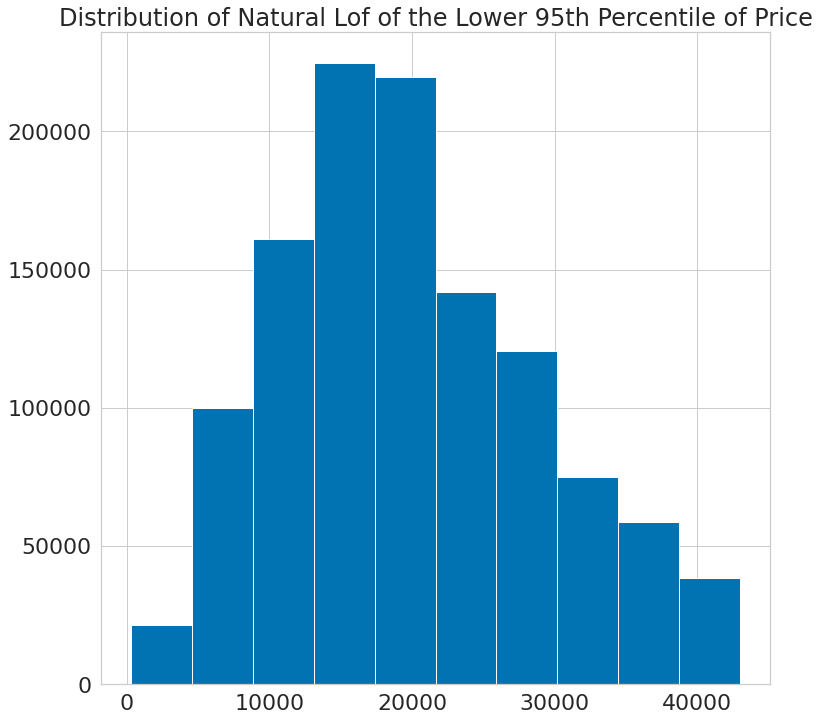

In [23]:
plt.figure(figsize=(12,12))
plt.hist(df[df['price'] < np.percentile(df['price'], 95)]['price'])
plt.title('Distribution of Natural Lof of the Lower 95th Percentile of Price')
plt.show()

In [24]:
# Mileage also has some extreme values
df['mileage'].describe().compute()

count   1222797.000
mean      56406.943
std       44692.397
min           0.000
25%       25285.000
50%       40176.000
75%       79840.000
max      399496.000
Name: mileage, dtype: float64

(array([167420., 322194., 251326., 109294.,  94160.,  83363.,  63000.,
         47319.,  32870.,  21281.]),
 array([     0. ,  16999.4,  33998.8,  50998.2,  67997.6,  84997. ,
        101996.4, 118995.8, 135995.2, 152994.6, 169994. ]),
 <BarContainer object of 10 artists>)

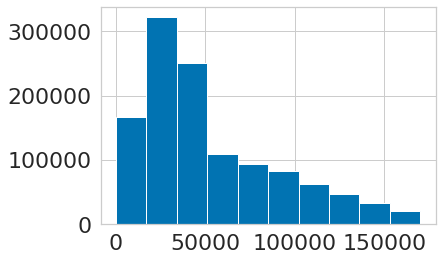

In [25]:
plt.hist(df[df['mileage'] < np.percentile(df['mileage'], 97.5)]['mileage'])

In [26]:
np.percentile(df['mileage'], 97.5)

169994.29999999958

In [27]:
df['daysonmarket'].describe().compute()

count   1222797.000
mean         54.053
std          93.438
min           0.000
25%          13.000
50%          28.000
75%          56.000
max        2979.000
Name: daysonmarket, dtype: float64

In [28]:
np.percentile(df['daysonmarket'], 95)

203.0

(array([475521., 293180., 175745.,  95284.,  50917.,  23508.,  12229.,
          7541.,  12448.,  15008.]),
 array([  0. ,  20.2,  40.4,  60.6,  80.8, 101. , 121.2, 141.4, 161.6,
        181.8, 202. ]),
 <BarContainer object of 10 artists>)

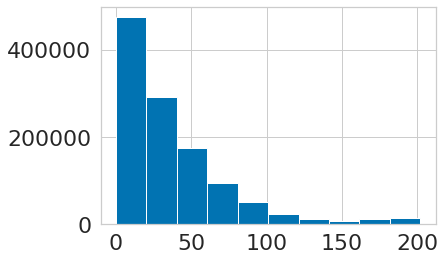

In [30]:
plt.hist(df[df['daysonmarket'] < np.percentile(df['daysonmarket'], 95)]['daysonmarket'])

Again the difficulty of fuel economy arises. Outliers would be hard to treat because the extrememly high values belong to hybrid vehicles and they are actually reasonable values. This is after already excluding electric only vehicles. Perhaps the populations are too different. For now I will leave those values untreated and see if there are negative impacts on performance.

In general the difficulty of cleaning these variables to have more normal distributions may preclude algorithms that assume a normal distribution. Luckly there are several performant alogrithms that do not assume normality and I will begin with those and revisit reshaping distributions later if necessary.

For now I will drop observations beyond the 95th percentile of price because I want this solution to generalize well.

Mileage has values that are proportionally less extreme. In this case I am not certain that cutting off before 200000 miles is entirely appropriate. I myself have purchased more than one car with that many miles but recognize that I am an outlier in this case and also that those cars were sold in a different context, usually through classified ads rather than an online listing platform geared towards auto-dealers. Therefore I will stick with dropping observations that are above the 97.5th percentile.

In [31]:
# Drop extreme values
df = df[df['price'] < np.percentile(df['price'], 95)]

df = df[df['mileage'] < np.percentile(df['mileage'], 97.5)]

df = df[df['daysonmarket'] < np.percentile(df['daysonmarket'], 95)]

# Convert production year to age
df['age'] = 2021 - df['year']
#df['age'] =  np.log(2022 - df['year'])

df = df.drop('year', axis=1)

In [32]:
# Write the data out to a more efficent format for further use.
df.to_parquet('cars_cleaned.parquet')

In [33]:
client.close()